In [1]:
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression

import matplotlib.pyplot as plt
import pandas as pd

##############################################################################
##########       Spark creat and transform data             #################
##############################################################################
## Spark Method ##
Full_data = spark.read.csv('train_V2.csv', sep=',', inferSchema=True, header=True)
# seperate match type
update_fun = (fn.when(fn.col('matchType').contains('solo'), 'solo').when(fn.col('matchType').contains('duo' or 'crash'), 'duo')
                .otherwise('squad'))
Full_data = Full_data.withColumn('matchType', update_fun)
##############################################################################
###### collect solo match
New_df_solo = Full_data.filter(Full_data.matchType == 'solo')
columns = ['Id','groupId','matchId','matchType']
New_df_solo = New_df_solo.select([col for col in New_df_solo.columns if col not in columns])
pj_sp_df_solo = New_df_solo.sample(withReplacement=False, fraction=0.1, seed=3)
##############################################################################
###### collect team match
New_df_team  = Full_data.select('*').groupby('groupId').agg(fn.sum('damageDealt').alias('total_team_damage'),
                      fn.sum('kills').alias('total_team_kills'),
                      fn.sum('killPoints').alias('team_kill_points'),
                      fn.avg('killPlace').alias('team_kill_rank'),
                      fn.avg('rankPoints').alias('team_normal_rank'),
                      fn.sum('revives').alias('team_revives'),
                      fn.sum('boosts').alias('team_boosts'),
                      fn.sum('assists').alias('total_assists'),
                      fn.sum('DBNOs').alias('team_DBNOs'),
                      fn.sum(Full_data.rideDistance + Full_data.walkDistance + Full_data.swimDistance).alias('totalDistance'))
New_df_team  = New_df_team.join(Full_data,New_df_team .groupId == Full_data.groupId)


##
columns = ['Id','groupId','matchId', 'roadKills','numGroups','rideDistance','walkDistance','swimDistance','kills','killPints','killPlace','rankPoints','revives','boosts','assists','DBNOs']
New_df_team = New_df_team.select([col for col in New_df_team.columns if col not in columns])

################################################################################
pj_sp_df_team = New_df_team.sample(withReplacement=False, fraction=0.1, seed=3)
##
#withColumn('solo',(fn.col('matchType') == 'solo').cast('int')).\
pj_sp_df_team = pj_sp_df_team.\
                    withColumn('duo',(fn.col('matchType') == 'duo').cast('int')).\
                    withColumn('squad',(fn.col('matchType') == 'squad').cast('int'))
pj_sp_df_team = pj_sp_df_team.drop('matchType')
pj_sp_df_team.show(5)
##############################################################################



+------------------+----------------+----------------+--------------+------------------+------------+-----------+-------------+----------+-------------+-----------+-------------+-----+----------+-----------+-----------+-------------+--------+---------+---------------+---------------+---------+------------+---+-----+
| total_team_damage|total_team_kills|team_kill_points|team_kill_rank|  team_normal_rank|team_revives|team_boosts|total_assists|team_DBNOs|totalDistance|damageDealt|headshotKills|heals|killPoints|killStreaks|longestKill|matchDuration|maxPlace|teamKills|vehicleDestroys|weaponsAcquired|winPoints|winPlacePerc|duo|squad|
+------------------+----------------+----------------+--------------+------------------+------------+-----------+-------------+----------+-------------+-----------+-------------+-----+----------+-----------+-----------+-------------+--------+---------+---------------+---------------+---------+------------+---+-----+
|            992.84|               9|         

In [2]:
#####################################################################
###############         Model Part       #############           
#####################################################################
#### Build a PCA Class
class PCA:
    def __init__(self,df):
        self.df = df
        self.inputcol = self.df.columns
        self.inputcol.remove('winPlacePerc')
    
    def Pipe_line(self,k):
         self.pipeline_PCA = Pipeline(stages=[
                            feature.VectorAssembler(inputCols=self.inputcol,outputCol='features'),
                            feature.StandardScaler(withMean=True,inputCol='features', outputCol='zfeatures'),
                            feature.PCA(k=k, inputCol='zfeatures', outputCol='loadings')
                            ]).fit(self.df)
         return self.pipeline_PCA
     
    def PC(self):
        self.principal_components = self.pipeline_PCA.stages[-1].pc.toArray()
        self.pca_model = self.pipeline_PCA.stages[-1]
        self.explainedVariance = self.pca_model.explainedVariance
        return {'PC':self.principal_components,"Model":self.pca_model,"EV":self.explainedVariance}
    
    def choose(self,th = 0.98):
        for i in range(0,1000):
             if self.explainedVariance[i] < 0.01:
                break
        print ('best k = ', i-1)
        self.sumEV = 0
        for i in range(0,1000):
             self.sumEV += self.explainedVariance[i]
             if self.sumEV > th:
                    break
        print ('best k = ', i-1)     
        plt.plot(np.cumsum(self.explainedVariance))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance')
    
    def Print_first2(self):
        pc1_pd =pd.DataFrame({'Feature': self.inputcol, 'abs_loading': abs(self.principal_components[:,0])}).sort_values('abs_loading',ascending=False)
        pc2_pd =pd.DataFrame({'Feature': self.inputcol, 'abs_loading': abs(self.principal_components[:,1])}).sort_values('abs_loading',ascending=False)
        return {'pc1':pc1_pd,'pc2':pc2_pd}
    
    def reduced_dm(self,n):
        PCA_choosed = self.principal_components[:,:n]
        tpdf = self.df.drop('winPlacePerc')
        sp_np = tpdf.toPandas().values
        pc_df_solo = np.dot(sp_np,PCA_choosed)
        pc_df_solo =pd.DataFrame(pc_df_solo)
        return pc_df_solo
        



best k =  16
best k =  15


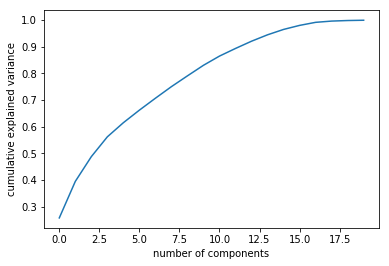

In [3]:
##########################################################      
##########    PCA  (solo)      #################### 
solo_model = PCA(pj_sp_df_solo)
solo_model.Pipe_line(20)
solo_model.PC()
solo_model.choose()


In [4]:
##########         PC Results first two dimension
pc1_pd = solo_model.Print_first2()['pc1']
pc2_pd = solo_model.Print_first2()['pc2']
##############      Reduced Dimension      #############################
pc_df_solo = solo_model.reduced_dm(15)
pc_df_solo.describe()
##########################################################  



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,72299.000000,72299.000000,72299.000000,72299.000000,72299.000000,72299.000000,72299.000000,72299.000000,72299.000000,72299.000000,72299.000000,72299.000000,72299.000000,72299.000000,72299.000000
mean,-410.819833,-72.733203,-286.088594,1210.092065,123.181233,-414.542677,352.898047,-379.592269,519.479403,-675.742288,35.851944,-578.664203,23.345775,254.563933,-359.394931
std,435.031802,1168.312139,259.793145,839.350949,331.546312,298.901387,161.089263,97.638623,139.794493,134.939894,220.371590,975.687224,354.487456,311.768753,235.350033
min,-5339.998736,-1727.899847,-2131.643685,-65.096232,-3269.266305,-7780.502264,-25.629177,-1093.309604,-12.773940,-2136.456243,-4015.407940,-2673.427029,-2846.290810,-3950.553861,-2996.370159
25%,-655.090284,-962.095341,-433.702110,764.186983,-28.241425,-438.916588,268.106212,-438.011422,432.332571,-786.336475,-71.638178,-971.619626,-214.105431,55.162123,-503.526637
50%,-228.804656,-924.846296,-313.478024,923.772288,197.624041,-333.531936,302.809391,-363.228876,470.897137,-633.186477,-26.545093,-790.178304,-127.059539,132.934712,-262.169045
75%,-72.223107,1370.649929,-62.109232,1318.069158,264.925423,-293.062721,377.241309,-310.962548,598.926546,-574.790957,140.611350,-690.802966,211.494527,410.134813,-177.290409
max,11.165771,1989.574032,300.912774,18820.686312,6596.021490,502.405023,4044.142623,255.964095,2988.160297,-92.725083,2473.811470,25910.240690,4363.748939,3932.399505,138.840580


best k =  16
best k =  16


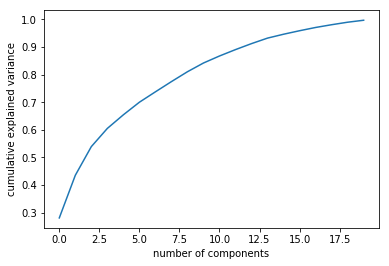

In [4]:
##########    PCA  (team)      #################### 
team_model = PCA(pj_sp_df_team)
team_model.Pipe_line(20)
team_model.PC()
team_model.choose()

In [5]:
##########         PC Results first two dimension
pc1_pd = team_model.Print_first2()['pc1']
pc2_pd = team_model.Print_first2()['pc2']
##############      Reduced Dimension      #############################
pc_df_team = team_model.reduced_dm(16)
pc_df_team.describe()
##########################################################  

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000,445074.000000
mean,-1424.641392,-567.505054,578.927431,2941.440392,-212.200923,259.348296,1528.485984,611.028332,611.290566,-179.177547,-1326.314352,-293.064715,-663.603477,-1662.876771,-76.079866,-2000.409498
std,1676.338250,2109.714834,881.452369,3130.702623,122.717787,549.368671,662.135428,212.798572,154.810943,695.332926,2298.107564,441.224700,1243.556025,2297.924182,781.197196,2153.280710
min,-58793.598186,-40552.731047,-1165.888529,-1208.503392,-2306.625729,-1072.012877,104.244928,-114.824112,-3295.607555,-24654.995987,-81256.995769,-15031.840629,-44293.487452,-81820.601756,-21354.155551,-60194.339501
25%,-2003.304864,-2304.723511,134.120498,914.766846,-251.124615,-60.481684,1071.132852,446.931079,534.450290,-406.467786,-2037.994789,-465.083337,-1046.745212,-2380.322798,-319.162242,-2925.370091
50%,-803.755675,862.859461,325.943860,1647.680059,-185.984850,52.060840,1331.085458,557.122989,610.315245,95.652956,-369.501244,-141.531351,-145.519683,-707.085159,30.356517,-1245.118825
75%,-295.002772,979.193086,867.698757,3880.236987,-143.119746,427.241901,1774.181398,715.588690,710.723874,263.204786,186.355511,18.384437,147.169612,-141.117062,133.661188,-360.335547
max,69.986089,7803.393830,30224.133187,110013.862052,3672.646979,18977.186348,21380.288526,6395.118291,3693.031600,973.290307,1701.304621,170.596964,709.458925,465.978528,14821.077066,212.246112


In [7]:
type(pc_df_solo)

pandas.core.frame.DataFrame

In [6]:
###########################################################################
#Combine pc dataframe with column 'winPlacePerc'
def combinedf(pc_df, pj_sp_df):
    pc_df1 =  spark.createDataFrame(pc_df)
    pc_df1=pc_df1.withColumn('index',fn.monotonically_increasing_id())
    pj_sp_df1 = pj_sp_df.select('winPlacePerc').withColumn('index',fn.monotonically_increasing_id())
    join_df = pc_df1.join(pj_sp_df1, on=['index'])
    return(join_df)

In [9]:
join_pc_df_solo = combinedf(pc_df_solo,pj_sp_df_solo)

In [10]:
inputcol = list(join_pc_df_solo.columns)
inputcol.remove('winPlacePerc')
inputcol.remove('index')

In [11]:
training_df, validation_df, testing_df = join_pc_df_solo.randomSplit([0.6, 0.3, 0.1], seed=0)
#############
## Linear
# RMSE Function
rmse = fn.sqrt(fn.mean((fn.col('winPlacePerc')-fn.col('prediction'))**2)).alias("rmse")   
def rmseLr(alpha,beta,maxiter = 100,fit_df = training_df, transform_df=validation_df):
    lr =  LinearRegression().\
        setLabelCol('winPlacePerc').\
        setFeaturesCol('scaledFeatures').\
        setRegParam(beta).\
        setMaxIter(maxiter).\
        setElasticNetParam(alpha)

    pipe_Lr_og = Pipeline(stages = [
      feature.VectorAssembler(inputCols = inputcol ,outputCol = 'feature'),
      feature.StandardScaler(withMean=True,inputCol="feature", outputCol="scaledFeatures"),
      lr
      #LogisticRegression(featuresCol = "scaledFeatures", labelCol = 'winPlacePerc')
      ]).fit(fit_df)

    coeff = pipe_Lr_og.stages[2].coefficients.toArray()
    coeffs_df = pd.DataFrame({'Features': inputcol, 'Coeffs': abs(coeff)})
    coeffs_df.sort_values('Coeffs', ascending=False)
    rmse3_df = pipe_Lr_og.transform(transform_df).select(rmse)
    return {'rmse':rmse3_df.show(),'pipe_model':pipe_Lr_og}

In [12]:
### Model 1  With all PC
rmseLr(0,0)['rmse']

+-------------------+
|               rmse|
+-------------------+
|0.29662893490471826|
+-------------------+



In [13]:
### Model 2 
rmseLr(1,0.1)['rmse']

+-------------------+
|               rmse|
+-------------------+
|0.29844617461228923|
+-------------------+



In [14]:
### Model 3 
rmseLr(0,0.1)['rmse']


+-------------------+
|               rmse|
+-------------------+
|0.29692618410136395|
+-------------------+



In [15]:
### Model 4 
rmseLr(0.5,0.1)['rmse']

+-------------------+
|               rmse|
+-------------------+
|0.29844617461228923|
+-------------------+



In [16]:
############### Model 1 is the best
### Model 1 for solo
rmseLr(0,0)['pipe_model'].transform(testing_df).select(rmse).show()
train_summary = rmseLr(0,0)['pipe_model'].stages[-1].summary
print("RMSE: %f" % train_summary.rootMeanSquaredError)
print("r2: %f" % train_summary.r2)



+-------------------+
|               rmse|
+-------------------+
|0.29662893490471826|
+-------------------+

+-------------------+
|               rmse|
+-------------------+
|0.29757241548569596|
+-------------------+

+-------------------+
|               rmse|
+-------------------+
|0.29662893490471826|
+-------------------+

RMSE: 0.296838
r2: 0.010531


In [19]:
pj_sp_df_team

DataFrame[total_team_damage: double, total_team_kills: bigint, team_kill_points: bigint, team_kill_rank: double, team_normal_rank: double, team_revives: bigint, team_boosts: bigint, total_assists: bigint, team_DBNOs: bigint, totalDistance: double, damageDealt: double, headshotKills: int, heals: int, killPoints: int, killStreaks: int, longestKill: double, matchDuration: int, maxPlace: int, teamKills: int, vehicleDestroys: int, weaponsAcquired: int, winPoints: int, winPlacePerc: double, duo: int, squad: int]

In [7]:
##############################################################
#Lr for team df
##############################################################
join_pc_df_team = combinedf(pc_df_team,pj_sp_df_team)
##############################################################


In [8]:
inputcol = list(join_pc_df_team.columns)
inputcol.remove('winPlacePerc')
inputcol.remove('index')
training_df, validation_df, testing_df = join_pc_df_team.randomSplit([0.6, 0.3, 0.1], seed=0)


In [9]:
#############
## Linear
# RMSE Function
rmse = fn.sqrt(fn.mean((fn.col('winPlacePerc')-fn.col('prediction'))**2)).alias("rmse")   
def rmseLr(alpha,beta,maxiter = 100,fit_df = training_df, transform_df=validation_df):
    lr =  LinearRegression().\
        setLabelCol('winPlacePerc').\
        setFeaturesCol('scaledFeatures').\
        setRegParam(beta).\
        setMaxIter(maxiter).\
        setElasticNetParam(alpha)

    pipe_Lr_og = Pipeline(stages = [
      feature.VectorAssembler(inputCols = inputcol ,outputCol = 'feature'),
      feature.StandardScaler(withMean=True,inputCol="feature", outputCol="scaledFeatures"),
      lr
      #LogisticRegression(featuresCol = "scaledFeatures", labelCol = 'winPlacePerc')
      ]).fit(fit_df)

    coeff = pipe_Lr_og.stages[2].coefficients.toArray()
    coeffs_df = pd.DataFrame({'Features': inputcol, 'Coeffs': abs(coeff)})
    coeffs_df.sort_values('Coeffs', ascending=False)
    rmse3_df = pipe_Lr_og.transform(transform_df).select(rmse)
    return {'rmse':rmse3_df.show(),'pipe_model':pipe_Lr_og}

In [10]:
### Model 1 for all the team PC  
rmseLr(0,0)['rmse']
### Model 2 
rmseLr(1,0.1)['rmse']
### Model 3 
rmseLr(0,0.1)['rmse']
### Model 4 
rmseLr(0.5,0.1)['rmse']

############### Model 1 is the best
### Model 1
rmseLr(0,0)['pipe_model'].transform(testing_df).select(rmse).show()
train_summary = rmseLr(0,0)['pipe_model'].stages[-1].summary
print("RMSE: %f" % train_summary.rootMeanSquaredError)
print("r2: %f" % train_summary.r2)

+-------------------+
|               rmse|
+-------------------+
|0.31020179790457064|
+-------------------+

+-------------------+
|               rmse|
+-------------------+
|0.31190672823633603|
+-------------------+

+------------------+
|              rmse|
+------------------+
|0.3113890150640713|
+------------------+

+-------------------+
|               rmse|
+-------------------+
|0.31190672823633603|
+-------------------+

+-------------------+
|               rmse|
+-------------------+
|0.31020179790454955|
+-------------------+

+-------------------+
|               rmse|
+-------------------+
|0.30909792035952366|
+-------------------+

+------------------+
|              rmse|
+------------------+
|0.3102017979045358|
+------------------+

RMSE: 0.303852
r2: 0.016943
